In [105]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-white')

## Load the dataset

In [70]:
# Load the dataset (6 csv files)
# Load the json file simultaneously, as we need to label the anomaly, and there are replicates in the timestamps
# Load the cpc and cpm files into different dataset
def load_file(anomaly, suffix):
    filepath = "./realAdExchange/"
    df = pd.DataFrame()
    
    for i in range(2, 5):
        filename = "exchange-" + str(i) + suffix
        cur = pd.read_csv(filepath + filename)
        cur['anomaly'] = 0
        cur.loc[cur.timestamp.isin(anomaly[filepath[2:] + filename]), 'anomaly'] = 1
        cur['dataset'] = filename
        df = df.append(cur)
    
    return df

with open('./labels.json') as f:
    anomaly = json.load(f)

df_cpc = load_file(anomaly, "_cpc_results.csv")
df_cpm = load_file(anomaly, "_cpm_results.csv")

In [71]:
df_cpc.head(5)

,timestamp,value,anomaly,dataset
0,2011-07-01 00:00:01,0.081965,0,exchange-2_cpc_results.csv
1,2011-07-01 01:00:01,0.098972,0,exchange-2_cpc_results.csv
2,2011-07-01 02:00:01,0.065314,0,exchange-2_cpc_results.csv
3,2011-07-01 03:00:01,0.070663,0,exchange-2_cpc_results.csv
4,2011-07-01 04:00:01,0.102490,0,exchange-2_cpc_results.csv


In [72]:
df_cpc.describe()

,value,anomaly
count,4805.000000,4805.000000
mean,0.107905,0.001457
std,0.091368,0.038144
min,0.023884,0.000000
25%,0.072492,0.000000
50%,0.097467,0.000000
75%,0.124019,0.000000
max,3.126852,1.000000


In [73]:
df_cpc.groupby('anomaly').count()

,timestamp,value,dataset
anomaly,,,
0,4798,4798,4798
1,7,7,7


In [74]:
df_cpm.head(5)

,timestamp,value,anomaly,dataset
0,2011-07-01 00:00:01,0.401048,0,exchange-2_cpm_results.csv
1,2011-07-01 01:00:01,0.392719,0,exchange-2_cpm_results.csv
2,2011-07-01 02:00:01,0.309996,0,exchange-2_cpm_results.csv
3,2011-07-01 03:00:01,0.212939,0,exchange-2_cpm_results.csv
4,2011-07-01 04:00:01,0.205801,0,exchange-2_cpm_results.csv


In [75]:
df_cpm.describe()

,value,anomaly
count,4805.000000,4805.000000
mean,0.543631,0.001457
std,0.517033,0.038144
min,0.000385,0.000000
25%,0.323628,0.000000
50%,0.489483,0.000000
75%,0.648013,0.000000
max,16.438200,1.000000


In [76]:
df_cpm.groupby('anomaly').count()

,timestamp,value,dataset
anomaly,,,
0,4798,4798,4798
1,7,7,7


In [77]:
df_cpc[df_cpc['anomaly'] == 1]

,timestamp,value,anomaly,dataset
325,2011-07-14 13:00:01,0.172900,1,exchange-2_cpc_results.csv
296,2011-07-14 10:15:01,0.905385,1,exchange-3_cpc_results.csv
438,2011-07-20 10:15:01,0.989074,1,exchange-3_cpc_results.csv
977,2011-08-13 10:15:01,0.332500,1,exchange-3_cpc_results.csv
367,2011-07-16 09:15:01,1.937843,1,exchange-4_cpc_results.csv
776,2011-08-02 12:15:01,0.239967,1,exchange-4_cpc_results.csv
1276,2011-08-23 08:15:01,3.126852,1,exchange-4_cpc_results.csv


## Plot the value based on the timestamp to view any pattern

In [116]:
df_cpc_sorted = df_cpc.sort_values(by = ['timestamp']).reset_index()
df_cpm_sorted = df_cpm.sort_values(by = ['timestamp']).reset_index()

In [117]:
df_cpc_sorted.head(5)

,index,timestamp,value,anomaly,dataset
0,0,2011-07-01 00:00:01,0.081965,0,exchange-2_cpc_results.csv
1,0,2011-07-01 00:15:01,0.102709,0,exchange-3_cpc_results.csv
2,0,2011-07-01 00:15:01,0.091795,0,exchange-4_cpc_results.csv
3,1,2011-07-01 01:00:01,0.098972,0,exchange-2_cpc_results.csv
4,1,2011-07-01 01:15:01,0.074414,0,exchange-4_cpc_results.csv


Text(0.5, 1.0, 'Time Series of CPC by date time')

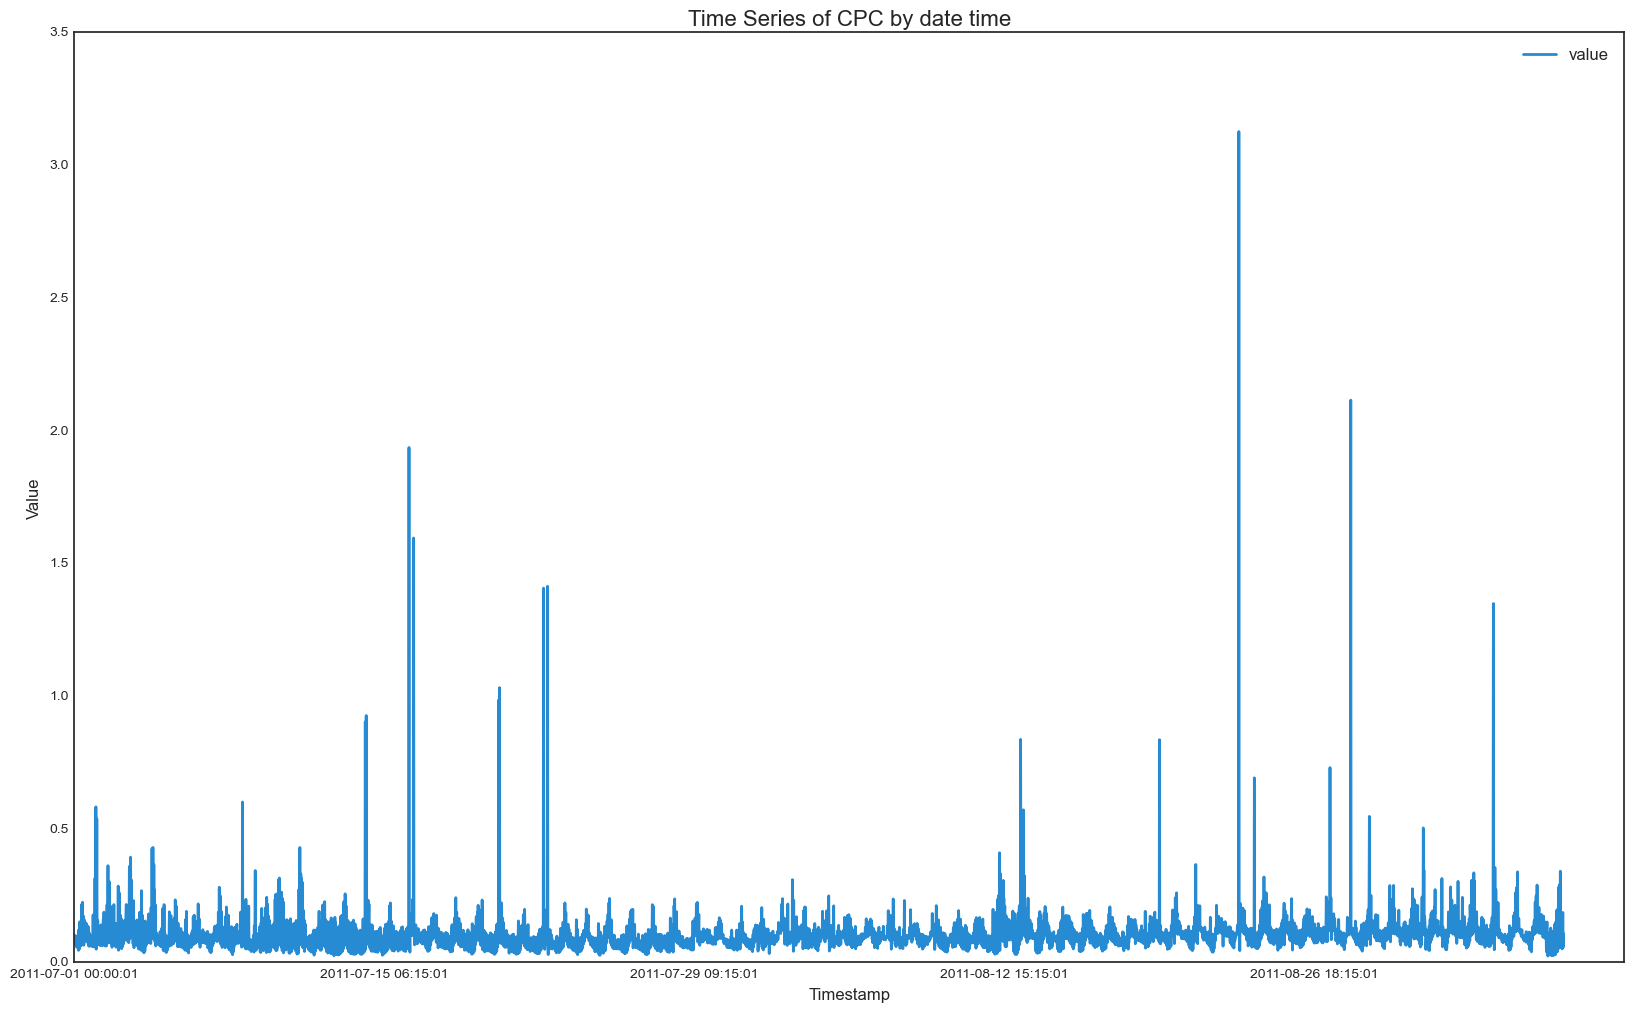

In [118]:
df_cpc_sorted.plot(x='timestamp', y='value', figsize = (20,12))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of CPC by date time')

Text(0.5, 1.0, 'Time Series of CPM by date time')

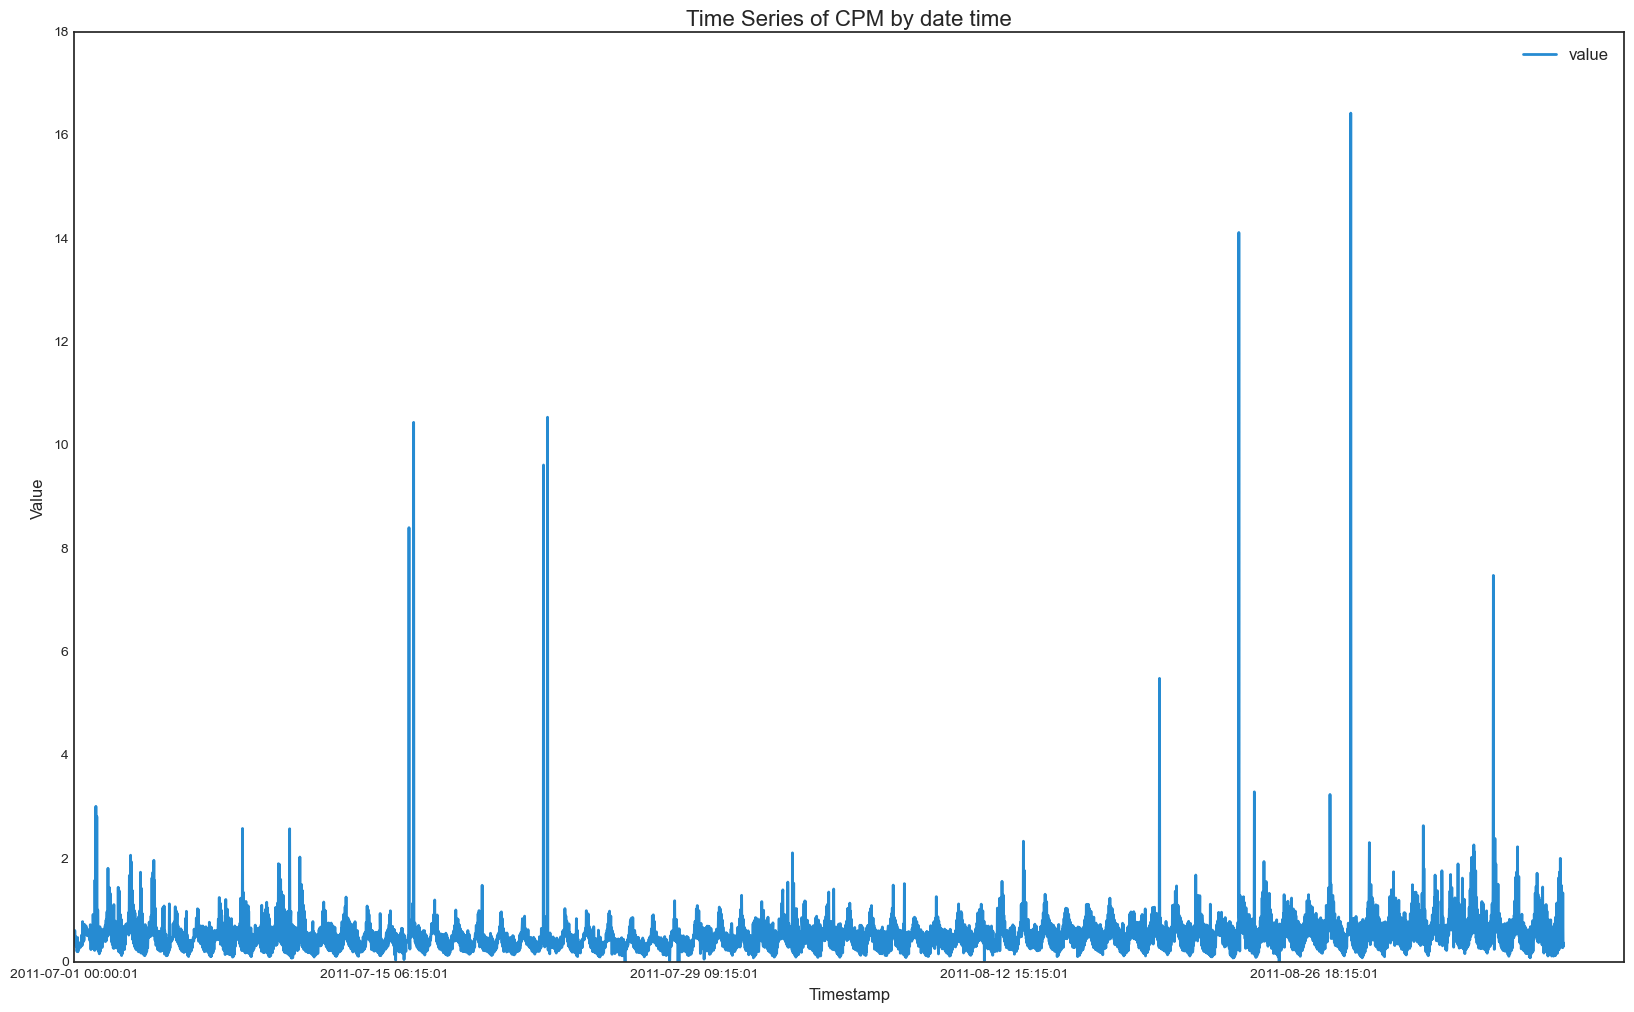

In [119]:
df_cpm_sorted.plot(x='timestamp', y='value', figsize = (20,12))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of CPM by date time')

Clearly, there is a pattern in the data. Thus, it is **NOT** correct to simply find the extreme data in the distribution. If we follow this way, some normal values will be misclassified. Instead, we need to use time series analysis in our anomaly detection.

## Algorithms

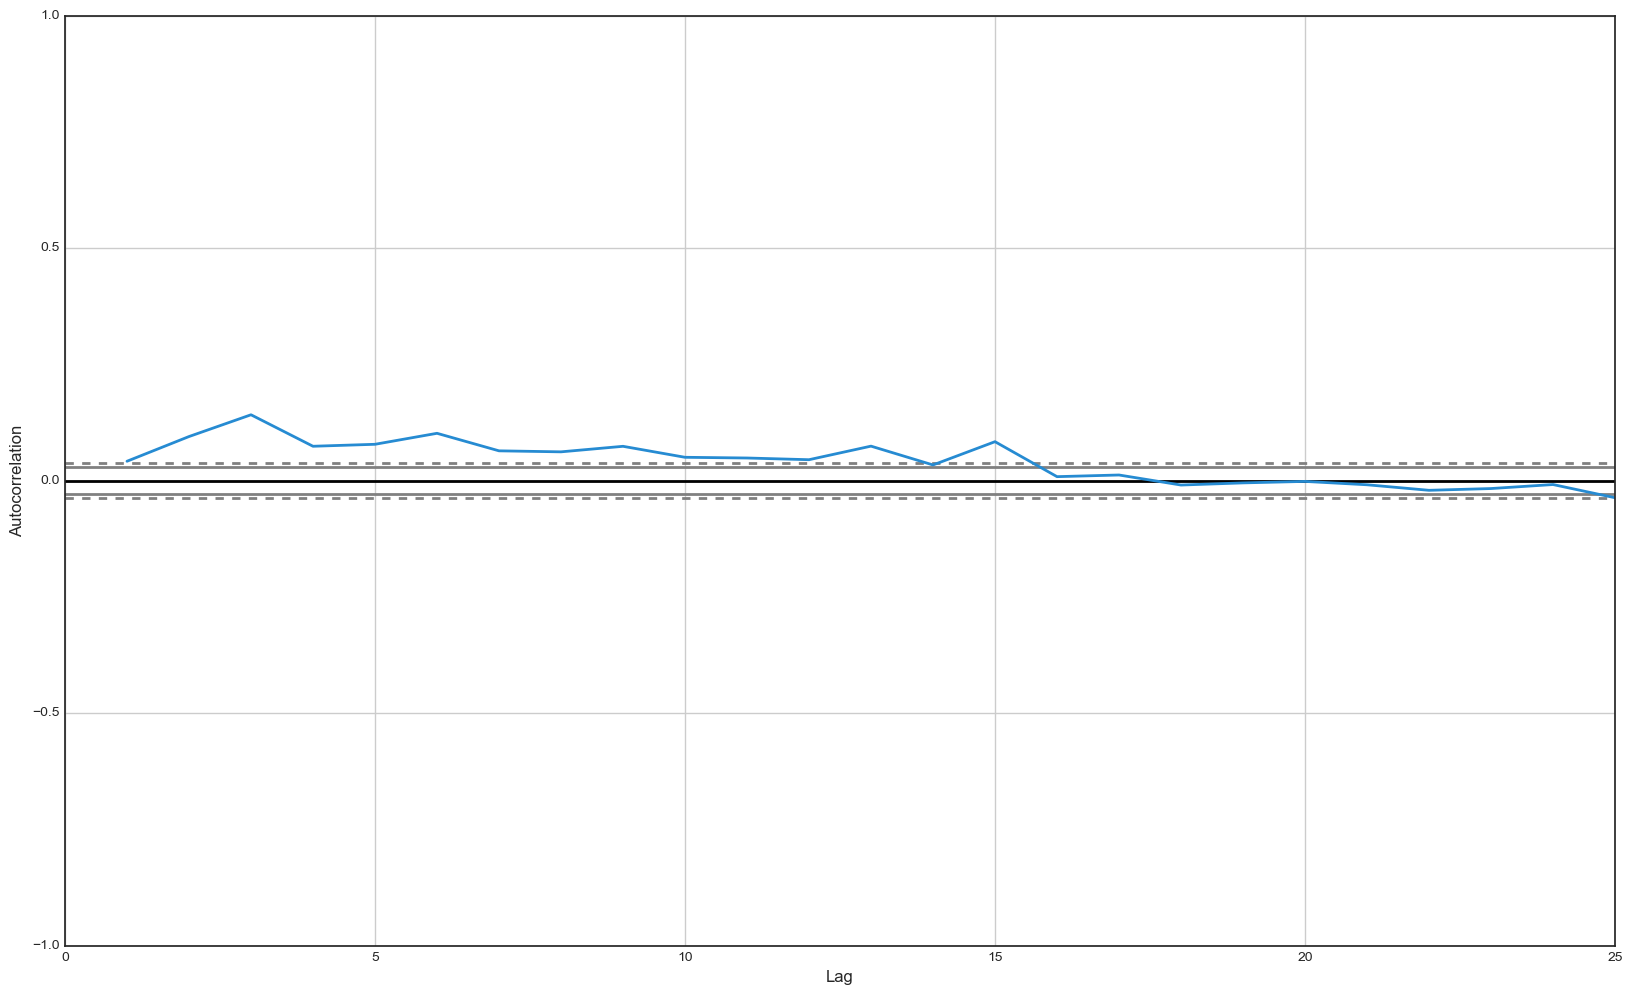

In [120]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_cpc_sorted['value'])
plt.xlim([0, 25])
plt.show()

This graph helps us determine the lag (number of previous periods which affect the current period). From the graph, it seems that 10 is a good choice.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4805
Model:                ARIMA(10, 2, 2)   Log Likelihood                4647.386
Date:                Wed, 17 Feb 2021   AIC                          -9268.771
Time:                        12:26:50   BIC                          -9184.570
Sample:                             0   HQIC                         -9239.200
                               - 4805                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8671      0.044    -42.908      0.000      -1.952      -1.782
ar.L2         -1.6849      0.044    -38.644      0.000      -1.770      -1.599
ar.L3         -1.3946      0.040    -34.853      0.0

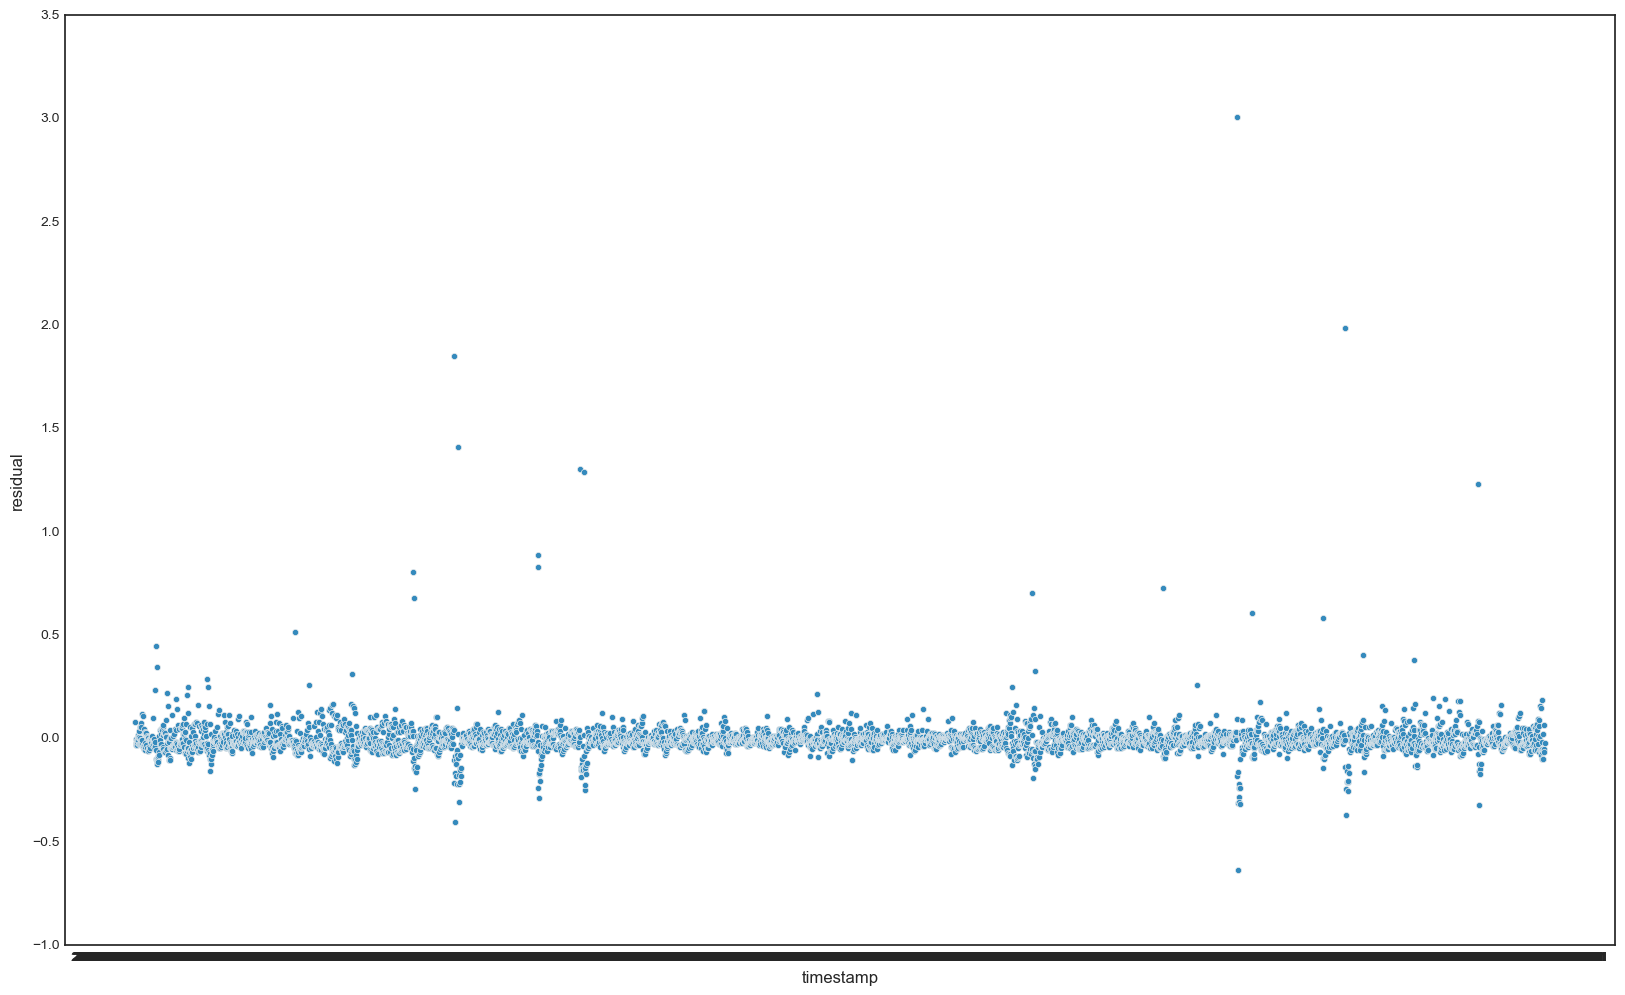

<Figure size 1200x600 with 0 Axes>

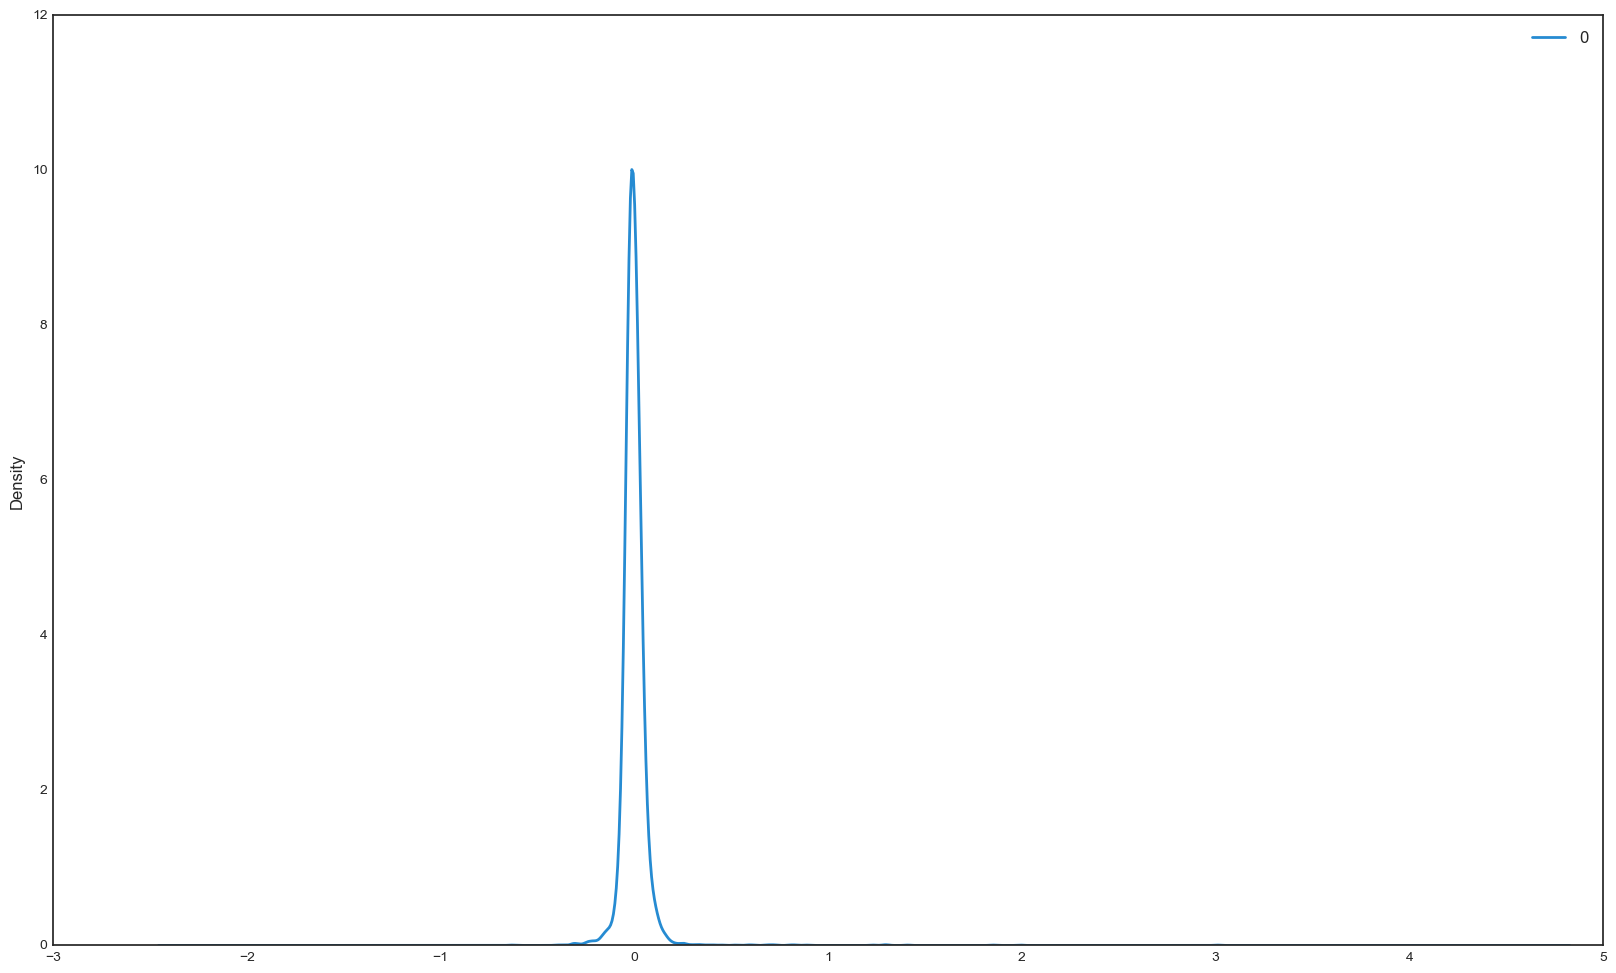

<Figure size 1200x600 with 0 Axes>

                 0
count  4805.000000
mean     -0.000108
std       0.091865
min      -0.634458
25%      -0.028474
50%      -0.005893
75%       0.020441
max       3.006946


In [156]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df_cpc_sorted['value'], order=(10, 2, 2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
df_cpc_sorted['residual'] = list(residuals.loc[:,0])
df_cpc_sorted.plot.scatter(x = 'timestamp', y = 'residual')
plt.figure(figsize = (12, 6))
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde')
plt.figure(figsize = (12, 6))
plt.show()

# summary stats of residuals
print(residuals.describe())

In [157]:
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

## Rolling Forecast ARIMA Model

In [131]:
output = model_fit.predict()
print(output)

0       0.000000
1       0.081965
2       0.091762
3       0.091839
4       0.094400
          ...   
4800    0.152125
4801    0.103816
4802    0.101333
4803    0.112937
4804    0.107210
Length: 4805, dtype: float64


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4805
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3721.151
Date:                Wed, 17 Feb 2021   AIC                           7454.302
Time:                        11:35:40   BIC                           7493.165
Sample:                             0   HQIC                          7467.950
                               - 4805                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9063      0.006   -140.773      0.000      -0.919      -0.894
ar.L2         -0.7701      0.007   -114.893      0.000      -0.783      -0.757
ar.L3         -0.5010      0.007    -75.632      0.0

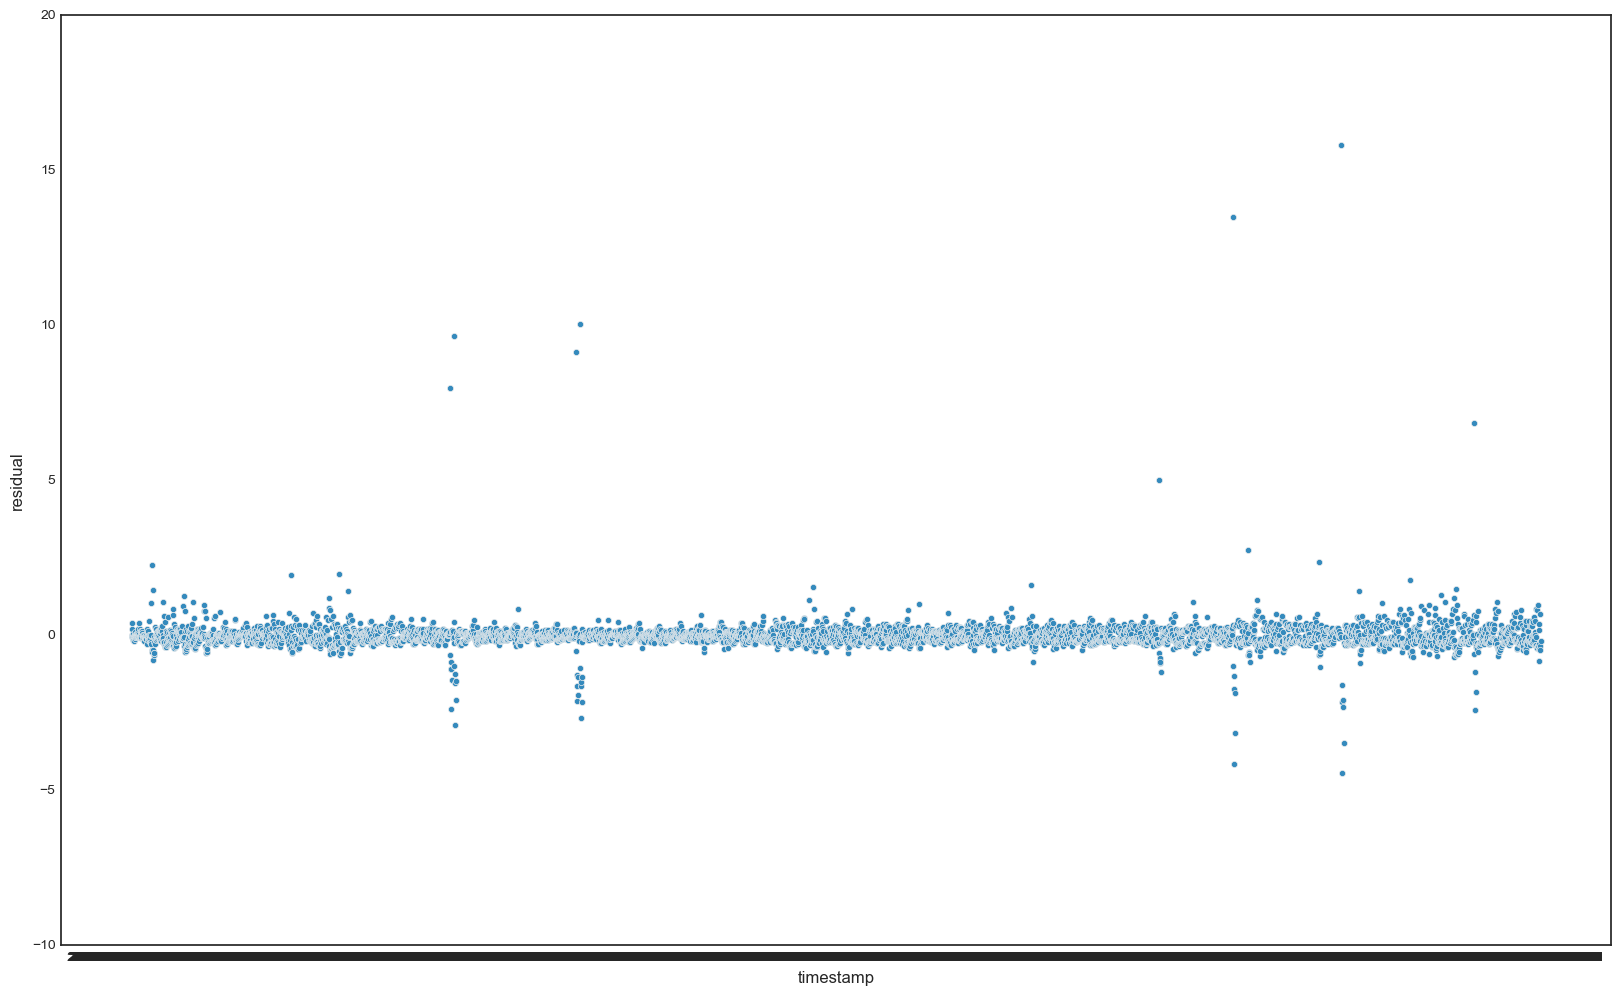

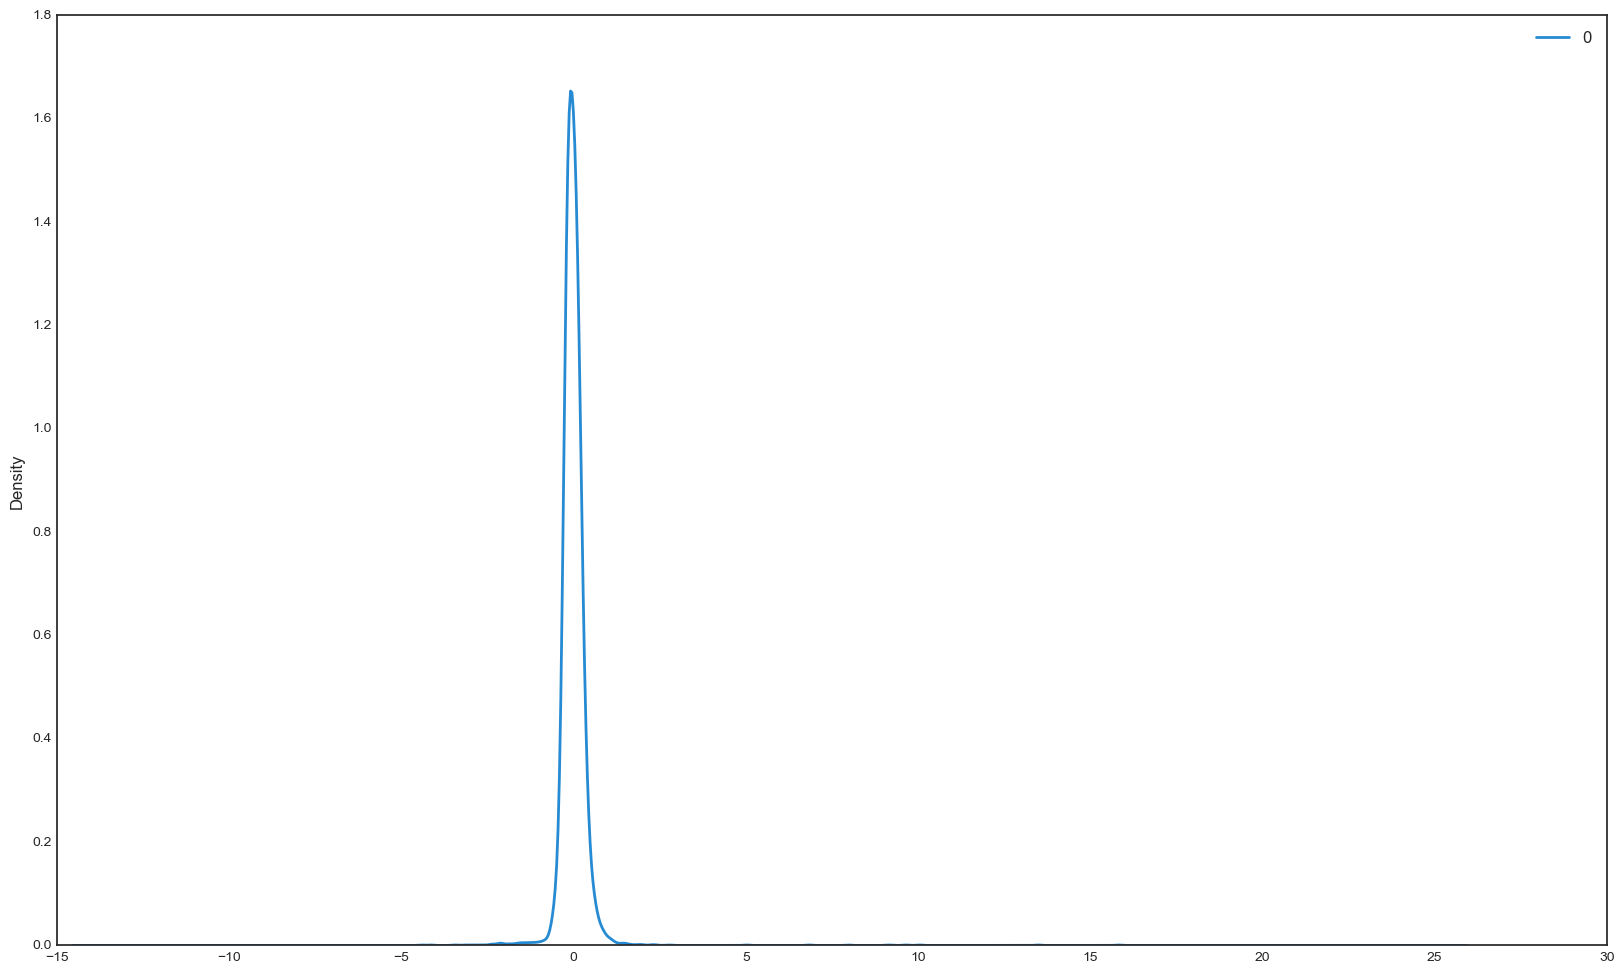

                 0
count  4805.000000
mean      0.000198
std       0.524973
min      -4.433415
25%      -0.172016
50%      -0.027159
75%       0.131371
max      15.804552


In [133]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df_cpm_sorted['value'], order=(5, 1, 0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
df_cpm_sorted['residual'] = list(residuals.loc[:,0])
df_cpm_sorted.plot.scatter(x = 'timestamp', y = 'residual')
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [139]:
df_cpc_sorted[df_cpc_sorted['anomaly'] == 1]

,index,timestamp,value,anomaly,dataset,residual
939,296,2011-07-14 10:15:01,0.905385,1,exchange-3_cpc_results.csv,0.808941
947,325,2011-07-14 13:00:01,0.172900,1,exchange-2_cpc_results.csv,-0.055521
1080,367,2011-07-16 09:15:01,1.937843,1,exchange-4_cpc_results.csv,1.844566
1370,438,2011-07-20 10:15:01,0.989074,1,exchange-3_cpc_results.csv,0.881466
2285,776,2011-08-02 12:15:01,0.239967,1,exchange-4_cpc_results.csv,0.092630
3055,977,2011-08-13 10:15:01,0.332500,1,exchange-3_cpc_results.csv,0.075072
3757,1276,2011-08-23 08:15:01,3.126852,1,exchange-4_cpc_results.csv,2.996752
